# **L1-3: Servo Mechanism Control System**

**CDS 110/ChE 105, Winter 2024** <br>
Richard M. Murray
</center>

In this lecture we show how to model an input/output system and design a controller for the system (using eigenvalue placement).

We consider a class of control systems know as *servomechanisms*.  Servermechanisms are mechanical systems that use feedback to provide high precision control of position and velocity.  Some examples of servomechanisms are shown below:

| | | |
| -- | -- | -- |
| Satellite Dish | Disk Drive | Robotics |
| <img src="https://www.cds.caltech.edu/~murray/courses/cds110/sp2024/satellite-dish.png" height=200 alt="Satellite Dish"> | <img src="https://www.cds.caltech.edu/~murray/courses/cds110/sp2024/disk-drive.png" height=200 alt="Disk Drive"> | <img src="https://www.cds.caltech.edu/~murray/courses/cds110/sp2024/robotic-arm.png" height=200 alt="Disk Drive">
| [YouTube video](https://www.youtube.com/watch?v=HSGfE_sC2hw) | [YouTube video](https://www.youtube.com/watch?v=oQh8KDea6SI) | [YouTube video](https://www.youtube.com/watch?v=hg3TIFIxWCo)
| | |

In [ ]:
# Import standard packages needed for this exercise
import numpy as np
import matplotlib.pyplot as plt
try:
  import control as ct
  print("python-control", ct.__version__)
except ImportError:
  !pip install control
  import control as ct

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 6.5 MB/s eta 0:00:00


## System dynamics

Consider a simple mechanism for positioning a mechanical arm whose equations of motion are given by

$$
J \ddot \theta = -b \dot\theta - k r\sin\theta + \tau_\text{m},
$$

which can be written in state space form as

$$
\frac{d}{dt} \begin{bmatrix} \theta \\ \theta \end{bmatrix} =
  \begin{bmatrix} \dot\theta \\ -k r \sin\theta / J - b\dot\theta / J \end{bmatrix}
  + \begin{bmatrix} 0 \\ 1/J \end{bmatrix} \tau_\text{m}.
$$

The system consists of a spring loaded arm that is driven by a  motor, as shown below.

<center><img src="https://www.cds.caltech.edu/~murray/courses/cds110/sp2024/servomech-diagram.png" alt="servomech-diagram" height="240"></center>

The motor applies a torque that twists the arm against a linear spring and moves the end of the arm across a rotating platter. The input to the system is the motor torque $\tau_\text{m}$. The force exerted by the spring is a nonlinear function of the head position due to the way it is attached.

The system parameters are given by

$$
k = 1,\quad J = 100,\quad b = 10,
\quad r = 1,\quad l = 2,\quad \epsilon = 0.01.
$$

and we assume that time is measured in msec and distance in cm.  (The constants here are made up and don't necessarily reflect a real disk drive, though the units and time constants are motivated by computer disk drives.)

The system dynamics can be modeled in python-control using a `NonlinearIOSystem` object, which we create with the `nlsys` function:

In [ ]:
# Parameter values
servomech_params = {
    'J': 100,             # Moment of inertial of the motor
    'b': 10,              # Angular damping of the arm
    'k': 1,               # Spring constant
    'r': 1,               # Location of spring contact on arm
    'l': 2,               # Distance to the read head
    'eps': 0.01,          # Magnitude of velocity-dependent perturbation
}

# State derivative
def servomech_update(t, x, u, params):
    # Extract the configuration and velocity variables from the state vector
    theta = x[0]                # Angular position of the disk drive arm
    thetadot = x[1]             # Angular velocity of the disk drive arm
    tau = u[0]                  # Torque applied at the base of the arm

    # Get the parameter values
    J, b, k, r = map(params.get, ['J', 'b', 'k', 'r'])

    # Compute the angular acceleration
    dthetadot = 1/J * (
        -b * thetadot - k * r * np.sin(theta) + tau)

    # Return the state update law
    return np.array([thetadot, dthetadot])

# System output (full state)
def servomech_output(t, x, u, params):
    l = params['l']
    return np.array([l * x[0], x[1]])

# System dynamics
servomech = ct.nlsys(
    servomech_update, servomech_output, name='servomech',
    params=servomech_params,
    states=['theta_', 'thdot_'],
    outputs=['y', 'thdot'], inputs=['tau'])

print(servomech)
print("\nParams:", servomech.params)

<NonlinearIOSystem>: servomech
Inputs (1): ['tau']
Outputs (2): ['y', 'thdot']
States (2): ['theta_', 'thdot_']

Update: <function servomech_update at 0x797b1af128c0>
Output: <function servomech_output at 0x797b1af12950>

Params: {'J': 100, 'b': 10, 'k': 1, 'r': 1, 'l': 2, 'eps': 0.01}


### Linearization

To study the open loop dynamicsof the system, we compute the linearization of the dynamics about the equilibrium point corresponding to $\theta_\text{e} = 15^\circ$.

In [ ]:
# Convert the equilibrium angle to radians
theta_e = (15 / 180) * np.pi

# Compute the input required to hold this position
u_e = servomech.params['k'] * servomech.params['r'] * np.sin(theta_e)
print("Equilibrium torque = %g" % u_e)

# Linearize the system about the equilibrium point
P = servomech.linearize([theta_e, 0], u_e)[0, 0]
print("Linearized dynamics:", P)

Equilibrium torque = 0.258819
Linearized dynamics: <StateSpace>: sys[0]$indexed
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.          1.        ]
     [-0.00965926 -0.1       ]]

B = [[0.  ]
     [0.01]]

C = [[2. 0.]]

D = [[0.]]



We can check the roots of the characteristic equation for this second order system using the `poles` method (we will learn how this works later in the term):

In [ ]:
# Check the stability of the equilibrium point
P.poles()

array([-0.05+0.08461239j, -0.05-0.08461239j])

Alternatively, we can look at the eigenvalues of the "dynamics matrix" for the linearized system (we will learn about this formulation in week 3):

In [ ]:
evals, evecs = np.linalg.eig(P.A)
print(evals)

[-0.05+0.08461239j -0.05-0.08461239j]


Both approaches give the same result and we see that the system is stable (negative real part) with an imaginary component (so we can expect some oscillation in the response).

### Open loop step response

A standard method for understanding the dynamics is to plot output of the system in response to an input that is set to 1 at time $t = 0$ (called the "step response").

We use the `step_response` function to plot the step response of the linearized, open-loop system and compute the "rise time" and "settling time" (we will define these more formally next week).

Rise time: 16.746073403576304
Settling time: 82.33486090091684


Text(41.16743045045842, 1.6, '$T_s$')

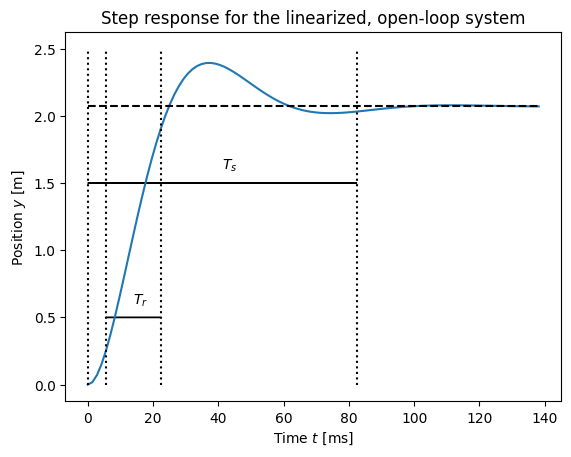

In [ ]:
# Compute the step response
lin_response = ct.step_response(P)
timepts, output = lin_response.time, lin_response.outputs

# Plot step response (input 0 to output 0)
plt.plot(timepts, output)
plt.xlabel("Time $t$ [ms]")
plt.ylabel("Position $y$ [m]")
plt.title("Step response for the linearized, open-loop system")

# Compute and print properties of the step response
results = ct.step_info(P)
print("Rise time:", results['RiseTime'])              # 10-90% rise time
print("Settling time:", results['SettlingTime'])      # 2% error

# Calculate the rise time start time by hand
rise_time_start = timepts[np.where(output > 0.1 * output[-1])[0][0]]
rise_time_stop = rise_time_start + results['RiseTime']

# Add lines for the step response features
plt.plot([timepts[0], timepts[-1]], [output[-1], output[-1]], 'k--')

plt.plot([rise_time_start, rise_time_start], [0, 2.5], 'k:')
plt.plot([rise_time_stop, rise_time_stop], [0, 2.5], 'k:')
plt.arrow(rise_time_start, 0.5, rise_time_stop - rise_time_start, 0)
plt.text((rise_time_start + rise_time_stop)/2, 0.6, '$T_r$')

plt.plot([0, 0], [0, 2.5], 'k:')
plt.plot([results['SettlingTime'], results['SettlingTime']], [0, 2.5], 'k:')
plt.arrow(0, 1.5, results['SettlingTime'], 0)
plt.text(results['SettlingTime']/2, 1.6, '$T_s$')


We see that the open loop step response (for the linearized system) is stable, and that the final value is larger than 1 (this value just depends on the parameters in the system).

We can also compare the response of the linearized system to the full nonlinear system:

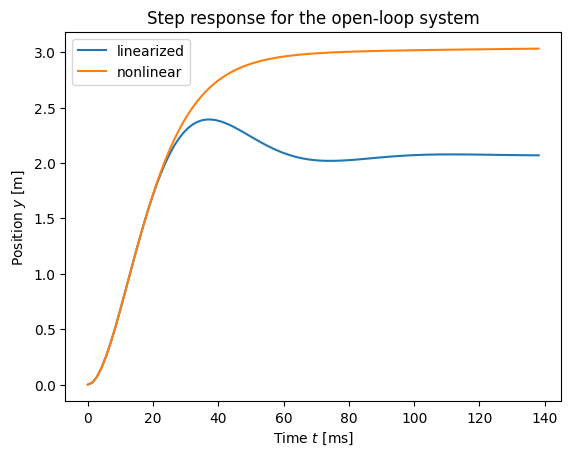

In [ ]:
nl_response = ct.input_output_response(servomech, timepts, U=1)

# Plot step response (input 0 to output 0)
plt.plot(timepts, output, label="linearized")
plt.plot(timepts, nl_response.outputs[0], label="nonlinear")

plt.xlabel("Time $t$ [ms]")
plt.ylabel("Position $y$ [m]")
plt.title("Step response for the open-loop system")
plt.legend()

We see that the nonlinear system responses differently.  This is because of the fact that the force exerted by the spring is nonlinear due to the kinematics of the mechanism design.

## Feedback control design

We next design a feedback controller for the system that that allows the system to track a desired position $y_\text{d}$  and sets the closed loop eigenvalues of the linearized system to $\lambda_{1,2} = −10 \pm 10 i$.

To do this, we make use of full state feedback of the form $u = -K(x - x_\text{d})$ where $x_\text{d}$ is the desired state of the system.  The python-control `place` command can be used to compute the state feedback gains $K$ that set the closed loop poles at a desired location:

In [ ]:
# Place the closed loop poles using feedback
# u = -K (x - xd)

# Find the gains required to place the gains at the desired location
K = ct.place(P.A, P.B, [-10 + 10*1j, -10 - 10*1j])
print(f"{K=}")

# Implement an I/O system implementing this control law
def statefbk_output(t, x, u, params):
  l = params.get('l', 2)
  # Create the current and desired state
  x = np.array([u[0] / l, u[1]])
  xd = np.array([u[2] / l, u[3]])
  return -K @ (x - xd)

statefbk = ct.nlsys(
    None, statefbk_output, name='statefbk',
    inputs=['y', 'thdot', 'y_d', 'thdot_d'],
    outputs=['tau']
)

K=array([[19999.03407484,  1990.00000005]])


Note that this controller has no internal state, but rather is a static input/output function.

We can now connect the controller to the the process using the `interconnect` command.  Because we have named the signals in a careful way, the `interconnect` command can automatically connect everthing together:

In [ ]:
clsys = ct.interconnect(
    [servomech, statefbk],
    inputs=['y_d', 'thdot_d'],
    outputs=['y', 'tau']
)

To examine the dynamics of the closed loop system, we plot the step response for the closed loop system and compute the rise time, settling time, and steady state error.


Rise time: 0.16326530612244897
Settling time: 0.42857142857142855
Steady state error (percent): 0.0015414911241684592


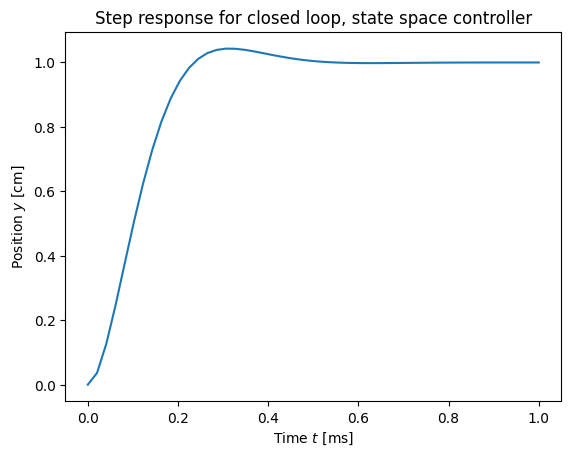

In [ ]:
# Compute the step response of the closed loop system
timepts = np.linspace(0, 1)
clsys_resp = ct.input_output_response(clsys, timepts, [1, 0])

plt.plot(clsys_resp.time, clsys_resp.outputs[0])
plt.xlabel("Time $t$ [ms]")
plt.ylabel("Position $y$ [cm]")
plt.title("Step response for closed loop, state space controller")

# Compute and print properties of the step response
results = ct.step_info(clsys_resp.outputs[0], timepts)
print("")
print("Rise time:", results['RiseTime'])
print("Settling time:", results['SettlingTime'])
print("Steady state error (percent):", abs(results['SteadyStateValue'] - 1) * 100)

Note the change in timescale (100 ms to 1 ms) and also the fact that the system now goes to the reference value ($y = 1$).

## Frequency response

Another way to measure the performance of the system is to compute its frequency response.

Roughly speaking, we set the input of the system to be of the form $u(t) = \sin(\omega t)$ and then look at the output signal $y(t)$.  For a *linear* system, we can show that the output signal will have the form

$$
y(t) = M sin(\omega t + \phi)
$$

where the magnitude $M$ and phase $\phi$ depend on the input frequency.

We can plot the magnitude (also called the "gain" of the system) and the phase as a function of the frequency $\omega$ and plot these values on a log-log and log-linear scale (called a *Bode* plot):

Bode plot:


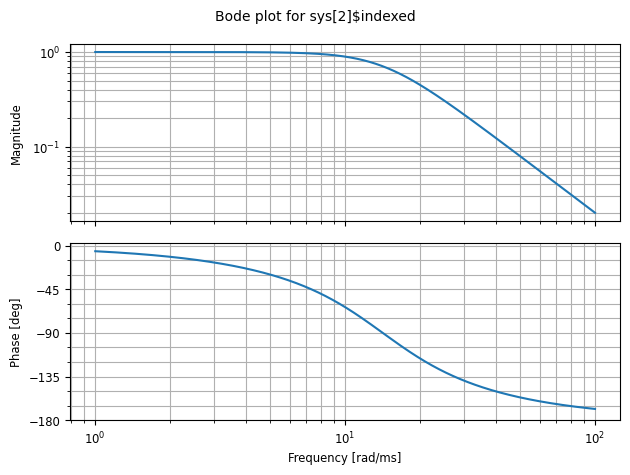

In [ ]:
# Compute the linearization of the closed loop system
G = clsys.linearize([theta_e, 0], [0, 0])

# Plot the Bode plot (input[0] = yd, outut[0] = y)
print("Bode plot:")
response = ct.frequency_response(G[0, 0])
out = response.plot()
axs = ct.get_plot_axes(out)
axs[1][0].set_xlabel("Frequency [rad/ms]");

Examination of the frequency response allows us to identify the range of input frequencies over which the control system can accurately track the input ($M(\omega) \approx 1$).  For this system, we have good tracking up to approximately 10 rad/ms, which corresponds to about 1.6 kHz.

## Trajectory tracking (if time)

Another type of analysis we might do is to see how well the system can track a more complicated reference trajectory.  For the disk drive example, we might move the system from one point on the disk to a second and then to a third (as we read different portions of the disk).

To explore this, we can create simulations of the full nonlinear system with the linear controllers designed above and plot the response of the system.  We do that here for a referend trajectory that has an initial value of 0 cm at $t = 0$, to 1 cm at $t = 0.5$, to 3 cm at $t = 1$, back to 2 cm at $t = 1.5$ ms:

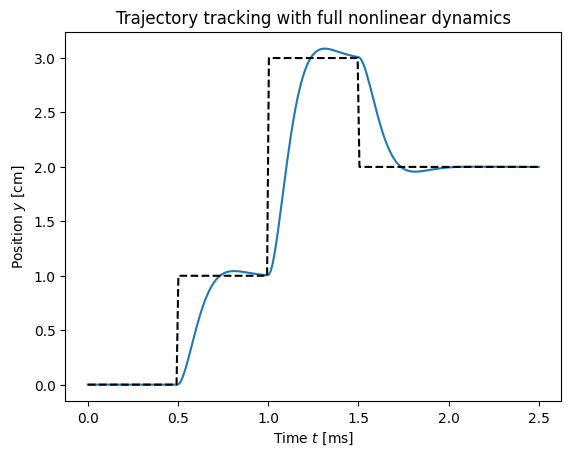

In [ ]:
# Create a reference trajectory to track
timepts = np.linspace(0, 2.5, 250)
ref = [
    np.concatenate((
        np.ones(50) * 0,
        np.ones(50) * 1,
        np.ones(50) * 3,
        np.ones(100) * 2,
    )), 0]

# Create the system response and plot the results
response = ct.input_output_response(clsys, timepts, ref)
plt.plot(response.time, response.outputs[0])

# Plot the reference trajectory
plt.plot(timepts, ref[0], 'k--');

# Label the plot
plt.xlabel("Time $t$ [ms]")
plt.ylabel("Position $y$ [cm]")
plt.title("Trajectory tracking with full nonlinear dynamics");